In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
from scipy.linalg import cho_factor, cho_solve

from Gaussian import Gaussian

In [12]:
# Helper functions.

def get_col_hist_grid(*arrays, bins=30, nrows=1, ncols=None, figsize=(5,4), hist_kwargs=None):
    """
    Given multiple (n, d) arrays (same d), return one matplotlib Figure per column.
    Each Figure contains one histogram per array (for that column).
    
    Parameters:
        *arrays: arbitrary number of numpy arrays, each shape (n, d)
        bins: number of histogram bins (default=30)
        hist_kwargs: dict of extra kwargs for plt.hist (optional)
        
    Returns:
        figs: list of matplotlib Figure objects (len=d)
    """
    
    n_cols = arrays[0].shape[1]
    if not all(a.shape[1] == n_cols for a in arrays):
        raise ValueError("All arrays must have the same number of columns")
        
    if hist_kwargs is None:
        hist_kwargs = {}
        
    if ncols is None:
        ncols = int(np.ceil(n_cols / nrows))
        
    fig, axs = plt.subplots(nrows, ncols, figsize=(figsize[0]*ncols, figsize[1]*nrows))
    axs = np.array(axs).reshape(-1)
    for col in range(n_cols):
        ax = axs[col]
        for idx, arr in enumerate(arrays):
            ax.hist(arr[:, col], bins=bins, alpha=0.5, label=f'Array {idx+1}', **hist_kwargs)
        ax.set_title(f'Column {col}')
        ax.legend()
        
    # Hide unused axes
    for k in range(n_cols, nrows*ncols):
        fig.delaxes(axs[k])
    return fig


# Solve linear Gaussian inverse problem.
def calc_post_moments(y, A, b, m, C, Sig):
    # Adjust for affine term.
    y_center = y - b

    # Cholesky factors of prior and noise covariances.
    C_chol, C_lower = cho_factor(C)
    Sig_chol, Sig_lower = cho_factor(Sig)

    # Compute Sig^{-1} m.
    q1 = cho_solve((C_chol, C_lower), m)

    # Compute Sig^{-1} (y-b)
    r1 = cho_solve((Sig_chol, Sig_lower), y_center)

    # Compute Sig^{-1} A
    r2 = cho_solve((Sig_chol, Sig_lower), A)

    # Posterior precision
    # P = C^{-1} + A^T Sig^{-1} A
    P = cho_solve((C_chol, C_lower), np.eye(C.shape[0])) + A.T @ r2

    # Compute right-hand side for posterior mean linear system.
    rhs = q1 + A.T @ r1

    # Solve for the posterior mean
    P_chol, P_lower = cho_factor(P)
    m_post = cho_solve((P_chol, P_lower), rhs)

    # Posterior covariance (via Cholesky)
    # C_post = P^{-1}
    # P x = I, so solve P_chol P_chol.T X = I
    C_post = cho_solve((P_chol, P_lower), np.eye(P.shape[0]))

    return m_post, C_post

In [3]:
# Test against scipy.
d = 10
L = np.random.normal(size=(d,d)) # Note that L is not the Cholesky factor (not PD)
C = L @ L.T
m = np.random.normal(size=d)
x_sp = mvn(mean=m, cov=C)

# From Cholesky factor.
x1 = Gaussian(mean=m, chol=np.linalg.cholesky(C, upper=False))

# From covariance.
x2 = Gaussian(mean=m, cov=C)

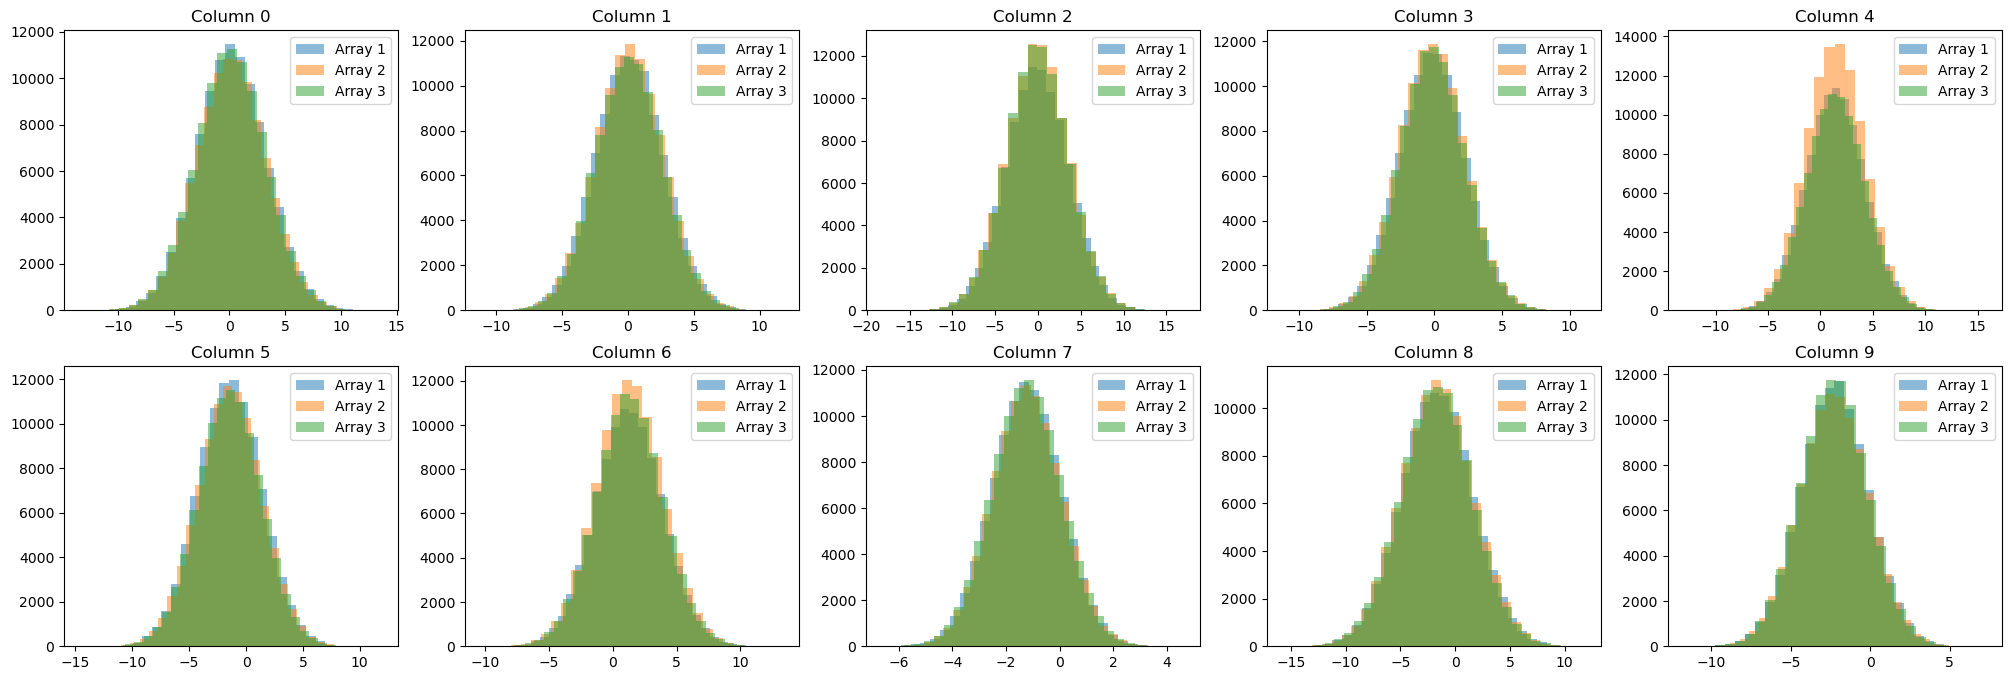

In [4]:
# Samples
n_samp = 100000
samp_sp = x_sp.rvs(size=n_samp)
samp_x1 = x1.sample(n_samp)
samp_x2 = x2.sample(n_samp)

hist_plt = get_col_hist_grid(samp_sp, samp_x1, samp_x2, bins=30, nrows=2)
plt.show()

In [5]:
# Density evaluations
dens_sp = x_sp.logpdf(samp_sp)
dens_x1 = x1.log_p(samp_sp)
dens_x2 = x2.log_p(samp_sp)

print(np.allclose(dens_sp, dens_x1))
print(np.allclose(dens_sp, dens_x2))

True
True


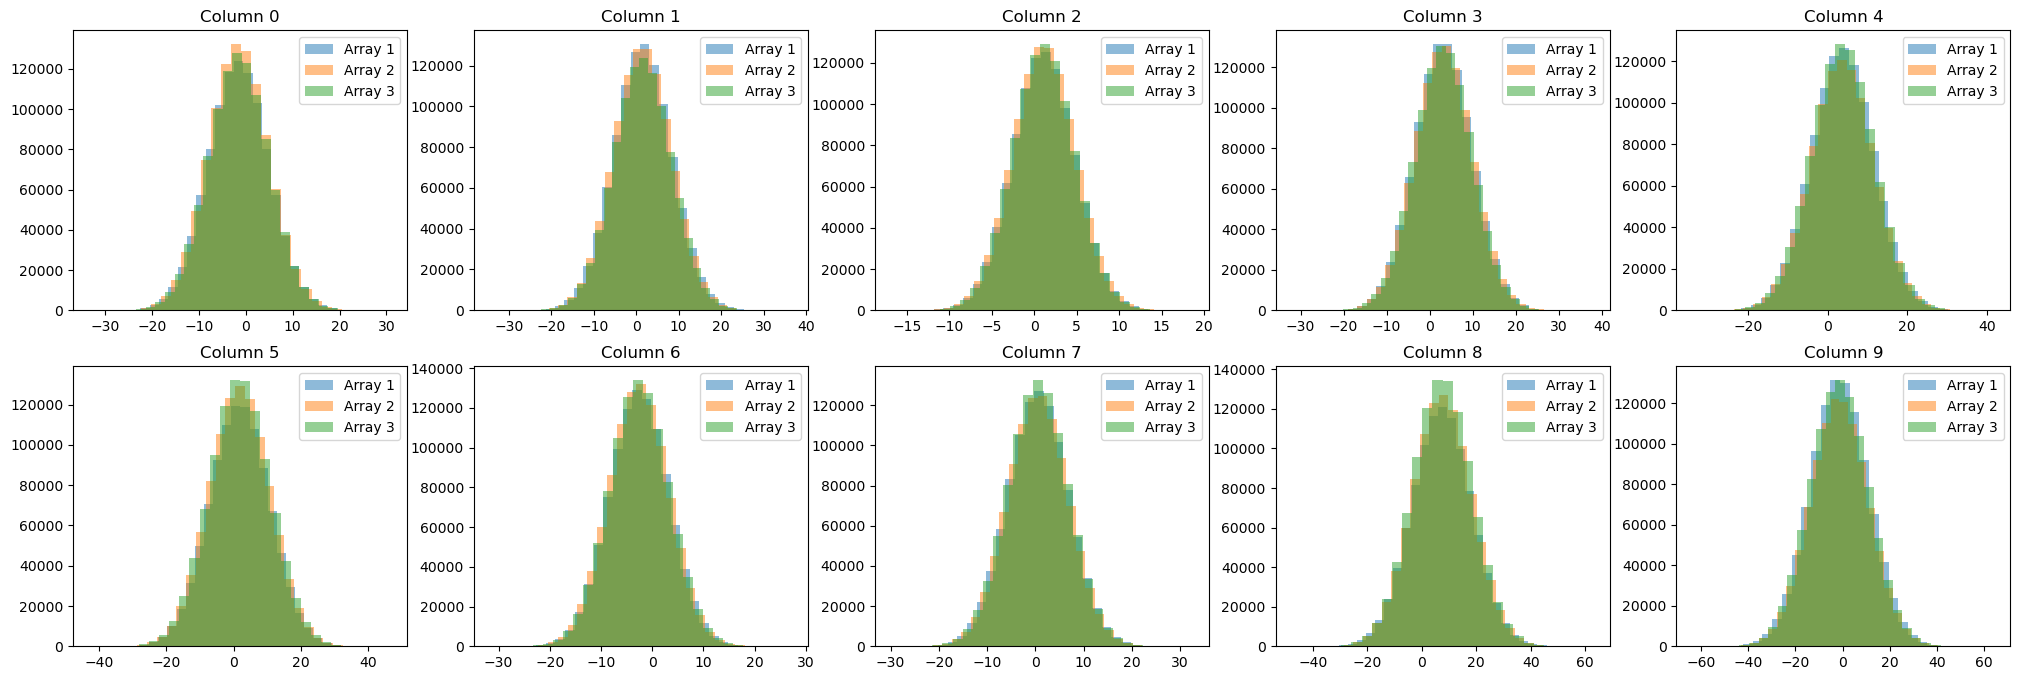

In [6]:
# Propagate through affine map.
n = 10
A = np.random.normal(size=(n, d))
b = np.random.normal(size=n)
F = lambda x: A @ x + b

y1 = x1.apply_affine_map(A,b)
y2 = x2.apply_affine_map(A,b, store="cov")

n_samp = 1000000
samp_y1 = y1.sample(n_samp)
samp_y2 = y2.sample(n_samp)
samp_sp = x_sp.rvs(size=n_samp)
samp_y_sp = np.array([F(row) for row in samp_sp])

hist_plt_y = get_col_hist_grid(samp_y_sp, samp_y1, samp_y2, bins=30, nrows=2)
plt.show()

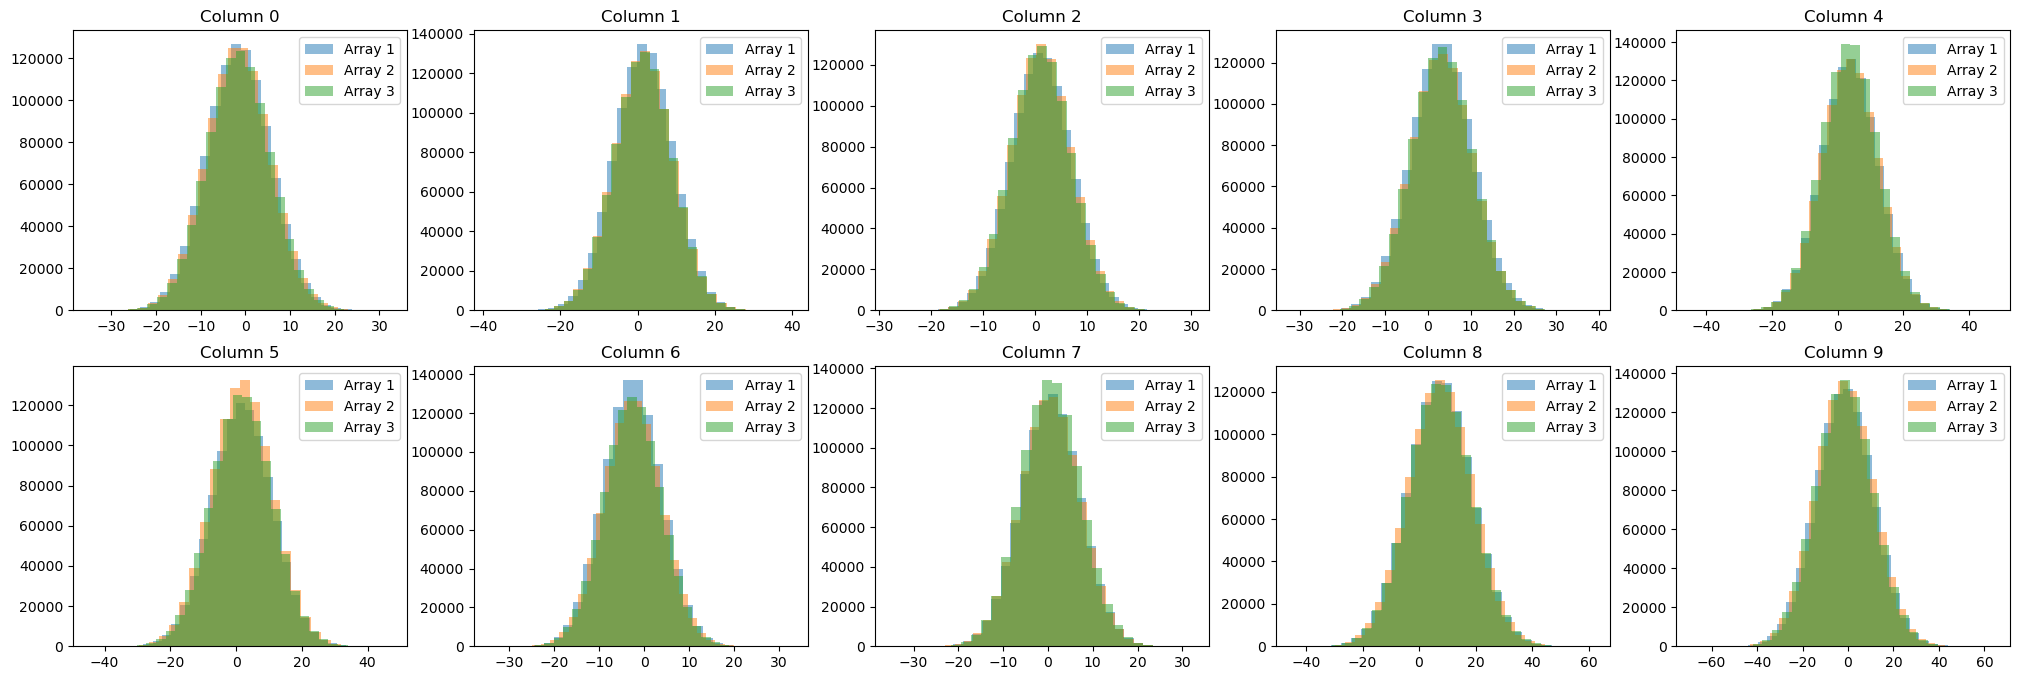

In [8]:
# Convolve with another Gaussian.
Sig_sqrt = np.random.normal(size=(n,n))
Sig = Sig_sqrt @ Sig_sqrt.T
samp_z_sp = samp_y_sp + mvn(cov=Sig).rvs(size=n_samp)

z1 = x1.convolve_with_Gaussian(A, b, Sig) 
z2 = x2.convolve_with_Gaussian(A, b, Sig, store="cov") 

samp_z1 = z1.sample(n_samp)
samp_z2 = z2.sample(n_samp)

hist_plt_z = get_col_hist_grid(samp_z_sp, samp_z1, samp_z2, bins=30, nrows=2)
plt.show()

In [19]:
# Solve linear Gaussian inverse problem.

# Continue from above setup - define data.
y = x1.convolve_with_Gaussian(A, b, Sig).sample(1).flatten()

# Ground truth.
m_post, C_post = calc_post_moments(y, A, b, m, C, Sig)

# Posterior random variable.
x1_post = x1.invert_affine_Gaussian(y, A, b, cov_noise=Sig, store="cov")
x2_post = x2.invert_affine_Gaussian(y, A, b, chol_noise=np.linalg.cholesky(Sig, upper=False), store="cov")

# Compare mean and cov.
print(np.allclose(m_post, x1_post.mean))
print(np.allclose(m_post, x2_post.mean))
print(np.allclose(C_post, x1_post.cov))
print(np.allclose(C_post, x2_post.cov))

# Plot.
n_samp = 100000
samp_sp_post = mvn(mean=m_post, cov=C_post).rvs(size=n_samp)
samp_x1_post = x1_post.sample(n_samp)
samp_x2_post = x2_post.sample(n_samp)

hist_plt_post = get_col_hist_grid(samp_sp_post, samp_x1_post, samp_x2_post, bins=30, nrows=2)
plt.show()

True
True
False
False


LinAlgError: 2-th leading minor of the array is not positive definite